In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

%matplotlib inline

from pandas import DataFrame
from IPython.display import Image

In [72]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals.six import StringIO
from sklearn.cross_validation import train_test_split

In [5]:
df = pd.read_csv("energy_efficiency.csv")
col=[10,11]
df.drop(df.columns[col], axis=1, inplace=True)
df.dropna(how="all", inplace=True)

yCols = [8,9]

X = df.drop(["Y1", "Y2"], axis=1)
X = np.array(X)

y = df[["Y1", "Y2"]]
y = np.array(y)

In [8]:
clf = DecisionTreeRegressor(max_depth=5)

In [9]:
clf.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [10]:
with open("clf.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

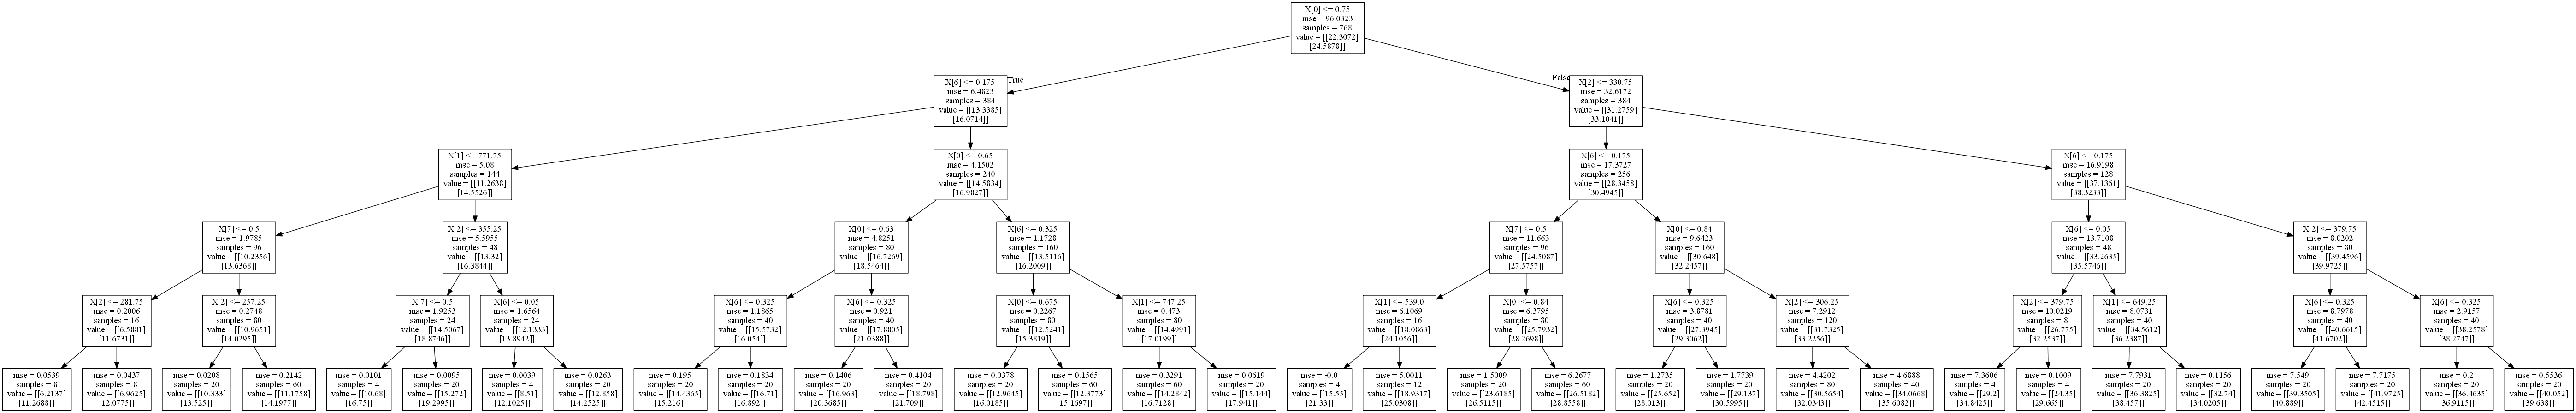

In [16]:
Image("clf.png")

In [12]:
#the image contains too many nodes. Let us try with a lower depth

clf2 = DecisionTreeRegressor(max_depth=3)
clf2.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [13]:
with open("clf2.dot", 'w') as f:
    f = tree.export_graphviz(clf2, out_file=f)

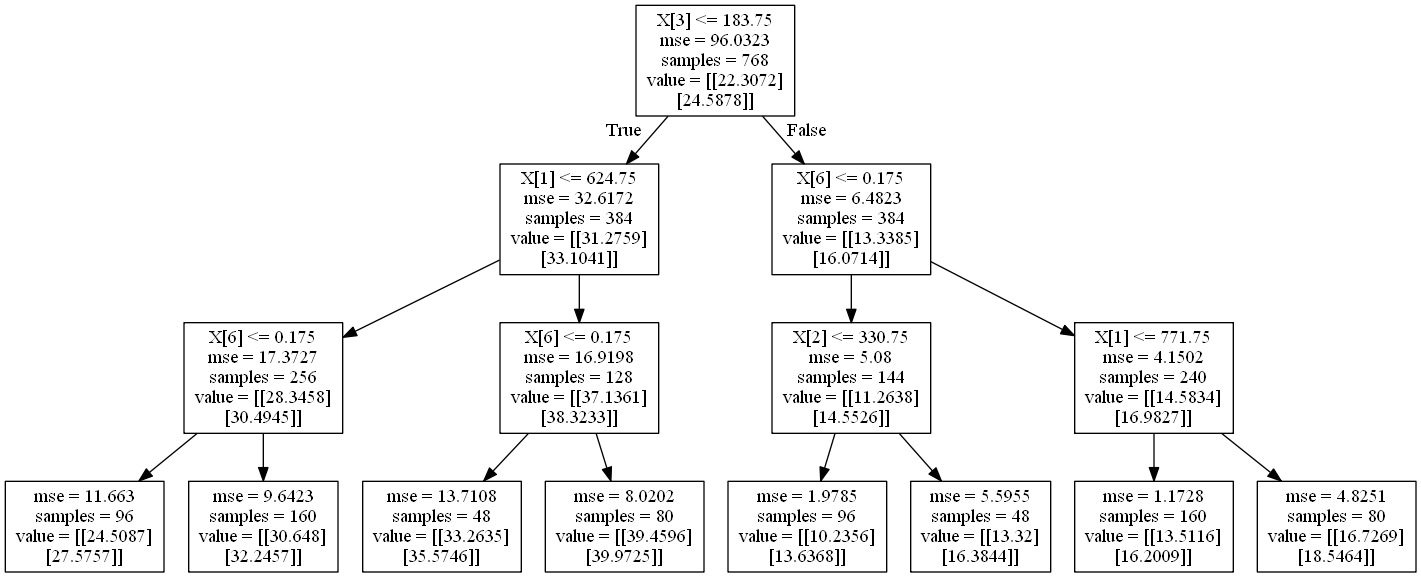

In [17]:
Image("clf2.png")

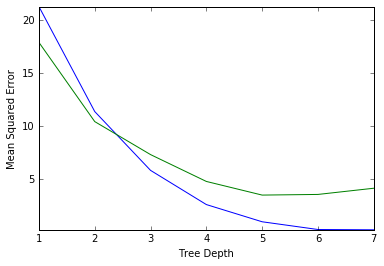

In [64]:
#use cv to determine the depth of trees that minimizes mse

depthList = [1,2,3,4,5,6,7]
xvalMSE = []
nxval = 10

nrow = len(X)

for i in depthList:
    for ixval in range(nxval):
        
        idxTest = [j for j in range(nrow) if j%nxval == ixval%nxval]
        idxTrain = [j for j in range(nrow) if j%nxval != ixval%nxval]
        
        # this simply takes each ordinal number 10 in the X and Y, where 10%10 (and multiple of 10)
        # produces no remainders. 
        # a good way to shuffle the test set rather than taking the last remaining set like other
        # authors always do in Iris tutorials.
        # but there are other sklearn package that can easily do this too
        
        xTrain = [X[k] for k in idxTrain]
        xTest = [X[k] for k in idxTest]
        yTrain = [y[k] for k in idxTrain]
        yTest = [y[k] for k in idxTest]
        
        clf4 = DecisionTreeRegressor(max_depth=i)
        clf4.fit(xTrain, yTrain)
        
        yHat = clf4.predict(xTest)
        error = [yTest[r] - yHat[r] for r in range(len(yTest))]
        
        if ixval == 0:
            oosErrors = sum([e * e for e in error]) #accummulating MSE (mean-squared error)
        
        else:
            oosErrors += sum([e * e for e in error])
            
    mse = oosErrors /nrow
    xvalMSE.append(mse)
        
#MSE = np.array(xvalMSE)
        
plt.plot(depthList, xvalMSE)
plt.axis("tight")
plt.xlabel("Tree Depth")
plt.ylabel("Mean Squared Error")


In [127]:
#Bagging

# random.seed(1)
# nSample = int(nrows * 0.30)
# idxTest = random.sample(range(nrows), nSample)
# idxTest.sort()
# idxTrain = [i for i in range(nrows if not(i in idxTest))]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=10)


#train models on subset of data, 30% as done by the train_test_split

def bagging(depth):
    treeDepth = depth
    numTreesMax = 30
#     treeDepth = 1
    modelList = []
    predList = []

    nBagSamples = int(len(x_train) * 0.5) #samples to be drawn for stochastic bagging

    for i in range(numTreesMax):
        idxBag = []
        for i in range(nBagSamples):
            idxBag.append(random.choice(range(len(x_train))))
        x_train_bag = [x_train[i] for i in idxBag]
        y_train_bag = [y_train[i] for i in idxBag]

        modelList.append(DecisionTreeRegressor(max_depth=treeDepth))
        modelList[-1].fit(x_train_bag, y_train_bag)

        latestPrediction = modelList[-1].predict(x_test)
        predList.append(list(latestPrediction))

    #build cumulative prediction from the first n models


    totalPredictions = []
    meansquarederror = []

    for i in range(len(modelList)):

        #average of first i of the prediction
        prediction = []
        for j in range(len(x_test)):
            prediction.append(sum([predList[k][j] for k in range(i + 1)])/(i + 1))

        totalPredictions.append(prediction)
        errors = [(y_test[k] - prediction[k]) for k in range(len(y_test))]
        meansquarederror.append(sum([e*e for e in errors]) / len(y_test))

    nModels = [i + 1 for i in range(len(modelList))]
    
    print("MSE on Depth of Trees = ", treeDepth)
    plt.plot(nModels,meansquarederror)
    plt.axis('tight')
    plt.xlabel('Number of Tree Models in Ensemble')
    plt.ylabel('Mean Squared Error')


(15, 20.0)

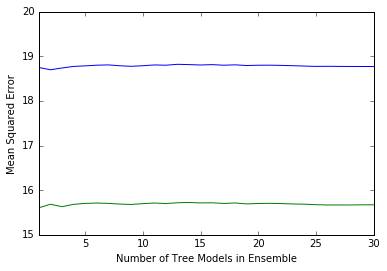

In [113]:
plt.plot(nModels,meansquarederror)
plt.axis('tight')
plt.xlabel('Number of Tree Models in Ensemble')
plt.ylabel('Mean Squared Error')
#plt.ylim((15, 20.0))

MSE on Depth of Trees =  1


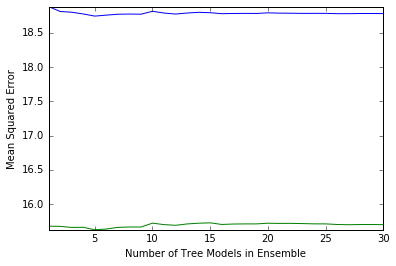

In [128]:
bagging(1)

MSE on Depth of Trees =  5


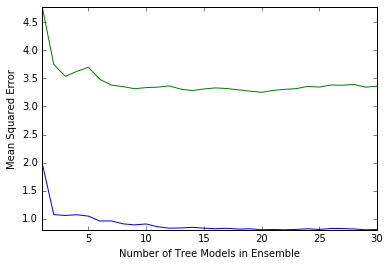

In [129]:
bagging(5)

MSE on Depth of Trees =  3


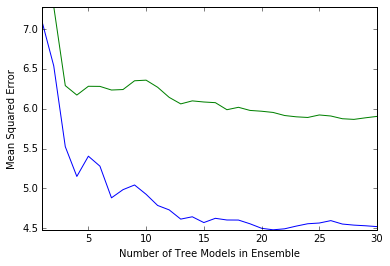

In [130]:
bagging(3)

In [149]:
# #Gradient Boosting

# #def boosting(depth):
# treeDepth = 5
# numTreesMax = 30
# #     treeDepth = 1

# modelList = []
# predList = []
# eps = 0.1 #number of gradient descent steps

# residuals = list(y_train)

# nBagSamples = int(len(x_train) * 0.5) #samples to be drawn for stochastic bagging

# for i in range(numTreesMax):

#     modelList.append(DecisionTreeRegressor(max_depth=treeDepth))
#     modelList[-1].fit(x_train, residuals)

#     latestPrediction = modelList[-1].predict(x_test)

#     #new prediction will update residuals
#     residuals = [residuals[j] - (eps * latestPrediction[j]) for j in range(len(residuals))]

#     latestOutOfSamplePrediction = modelList[-1].predict(x_test)
#     predList.append(list(latestOutOfSamplePrediction))

# #build cumulative prediction from the first n models


# totalPredictions = []
# meansquarederror = []

# for i in range(len(modelList)):

#     #average of first i of the prediction
#     prediction = []
#     for j in range(len(x_test)):
#         prediction.append(sum([predList[k][j] for k in range(i + 1)])*eps)

#     totalPredictions.append(prediction)
#     errors = [(y_test[k] - prediction[k]) for k in range(len(y_test))]
#     meansquarederror.append(sum([e*e for e in errors]) / len(y_test))

# nModels = [i + 1 for i in range(len(modelList))]

# print("MSE on Depth of Trees = ", treeDepth)
# plt.plot(nModels,meansquarederror)
# plt.axis('tight')
# plt.xlabel('Number of Tree Models in Ensemble')
# plt.ylabel('Mean Squared Error')


